In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [33]:
# Load the dataset
df = pd.read_csv('../../Data/pre_BTC-USD.csv')
# data = df['Close'].values.reshape(-1, 1)

In [34]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-03-01,10385.000000,11052.299805,10352.700195,10951.000000,10951.000000,7317279744
1,2018-03-02,10977.400391,11189.000000,10850.099609,11086.400391,11086.400391,7620590080
2,2018-03-03,11101.900391,11528.200195,11002.400391,11489.700195,11489.700195,6690570240
3,2018-03-04,11497.400391,11512.599609,11136.099609,11512.599609,11512.599609,6084149760
4,2018-03-05,11532.400391,11704.099609,11443.900391,11573.299805,11573.299805,6468539904


In [35]:
df= df.drop(columns=["Open", "High", "Low", "Adj Close","Volume"])
df = df.rename(columns={'Close': 'Price'})
df = pd.DataFrame(data=df)
data = df

In [36]:
# Chuyển đổi cột Date sang định dạng datetime64
df['Date'] = pd.to_datetime(df['Date'])

# Tạo cột Days_Since_Start và gán giá trị từ 1, 2, 3,...
df['Days_Since_Start'] = (df['Date'] - df['Date'].min()).dt.days + 1

# Kết quả
print(df)

           Date         Price  Days_Since_Start
0    2018-03-01  10951.000000                 1
1    2018-03-02  11086.400391                 2
2    2018-03-03  11489.700195                 3
3    2018-03-04  11512.599609                 4
4    2018-03-05  11573.299805                 5
...         ...           ...               ...
2280 2024-05-28  68296.218750              2281
2281 2024-05-29  67578.093750              2282
2282 2024-05-30  68364.992188              2283
2283 2024-05-31  67491.414063              2284
2284 2024-06-01  67706.937500              2285

[2285 rows x 3 columns]


In [37]:
#data["Price"]=data["Price"]*100

In [38]:
# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
split_ratio = 0.8
split_index = int(len(data) * split_ratio)
train, test = data.iloc[:split_index], data.iloc[split_index:]

In [39]:
def forecast_arima(train, steps):
    model = ARIMA(train, order=(1, 1, 1))
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=steps)
    return forecast

def forecast_linear_regression(train, steps):
    X = np.arange(len(train)).reshape(-1, 1)
    y = train['Price'].values
    model = LinearRegression()
    model.fit(X, y)
    X_pred = np.arange(len(train), len(train) + steps).reshape(-1, 1)
    forecast = model.predict(X_pred)
    return forecast

def forecast_decision_tree(train, steps):
    X = np.arange(len(train)).reshape(-1, 1)
    y = train['Price'].values
    model = DecisionTreeRegressor()
    model.fit(X, y)
    X_pred = np.arange(len(train), len(train) + steps).reshape(-1, 1)
    forecast = model.predict(X_pred)
    return forecast

In [40]:
# Train models and forecast for training set
arima_train_forecast = forecast_arima(train['Price'], len(train))
lr_train_forecast = forecast_linear_regression(train, len(train))
dt_train_forecast = forecast_decision_tree(train, len(train))

In [41]:
arima_train_forecast

1828    23481.684674
1829    23481.082899
1830    23481.141139
1831    23481.135503
1832    23481.136048
            ...     
3651    23481.136000
3652    23481.136000
3653    23481.136000
3654    23481.136000
3655    23481.136000
Name: predicted_mean, Length: 1828, dtype: float64

In [42]:
train['Price']

0       10951.000000
1       11086.400391
2       11489.700195
3       11512.599609
4       11573.299805
            ...     
1823    23561.212891
1824    23522.871094
1825    23147.353516
1826    23646.550781
1827    23475.466797
Name: Price, Length: 1828, dtype: float64

In [43]:
arima_train_forecast.index = train['Price'].index

In [44]:
# Calculate errors for training forecasts
errors_arima = train['Price'] - arima_train_forecast
errors_lr = train['Price'] - lr_train_forecast
errors_dt = train['Price'] - dt_train_forecast

In [45]:
print(errors_arima.describe())

count     1828.000000
mean     -2805.555394
std      16898.915441
min     -20244.374281
25%     -15770.860854
50%     -12053.432875
75%      10247.635484
max      44085.692125
dtype: float64


In [46]:
# Adjust forecasts using AR process for each model based on training errors
adjusted_arima_model = AutoReg(errors_arima, lags=1).fit()
adjusted_lr_model = AutoReg(errors_lr, lags=1).fit()
adjusted_dt_model = AutoReg(errors_dt, lags=1).fit()

In [47]:
len(errors_arima) + len(test) - 1

2284

In [48]:
# Forecast for test set using adjusted models
adjusted_forecasts_arima = arima_train_forecast.iloc[-1] + adjusted_arima_model.predict(start=len(errors_arima), end=len(errors_arima) + len(test) - 1)
adjusted_forecasts_lr = lr_train_forecast[-1] + adjusted_lr_model.predict(start=len(errors_lr), end=len(errors_lr) + len(test) - 1)
adjusted_forecasts_dt = dt_train_forecast[-1] + adjusted_dt_model.predict(start=len(errors_dt), end=len(errors_dt) + len(test) - 1)


In [49]:
# Combine adjusted forecasts for test set
adjusted_forecasts_combined = np.mean([adjusted_forecasts_arima, adjusted_forecasts_lr, adjusted_forecasts_dt], axis=0)
# adjusted_forecasts_combined = np.mean([adjusted_forecasts_lr, adjusted_forecasts_dt], axis=0)

In [50]:

# Tính các chỉ số đánh giá MAE, MSE, MAPE
mae = mean_absolute_error(test['Price'], adjusted_forecasts_combined)
mse = mean_squared_error(test['Price'], adjusted_forecasts_combined)
mape = np.mean(np.abs((test['Price'].values - adjusted_forecasts_combined) / test['Price'].values)) * 100

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'MAPE: {mape}%')

MAE: 14618.614588214232
MSE: 424866726.9530265
MAPE: 29.24460886742898%


# Predict 

In [51]:
future_steps = 90

In [52]:

# Forecast for test set using adjusted models
adjusted_forecasts_arima = arima_train_forecast.iloc[-1] + adjusted_arima_model.predict(start=len(errors_arima), end=len(errors_arima) + len(test) + future_steps)
adjusted_forecasts_lr = lr_train_forecast[-1] + adjusted_lr_model.predict(start=len(errors_lr), end=len(errors_lr) + len(test) + future_steps)
adjusted_forecasts_dt = dt_train_forecast[-1] + adjusted_dt_model.predict(start=len(errors_dt), end=len(errors_dt) + len(test) + future_steps)

In [53]:
adjusted_forecasts_combined = np.mean([adjusted_forecasts_arima, adjusted_forecasts_lr, adjusted_forecasts_dt], axis=0)

In [54]:
# Create date range for future forecasts
future_dates = range(0, len(data) + future_steps + 1)

In [55]:
future_index = len(future_dates)

In [56]:
# future_dates = pd.Index(future_dates)

In [57]:
test_index = range(len(train), len(data) + future_steps + 1)

In [58]:
len(adjusted_forecasts_combined)

548

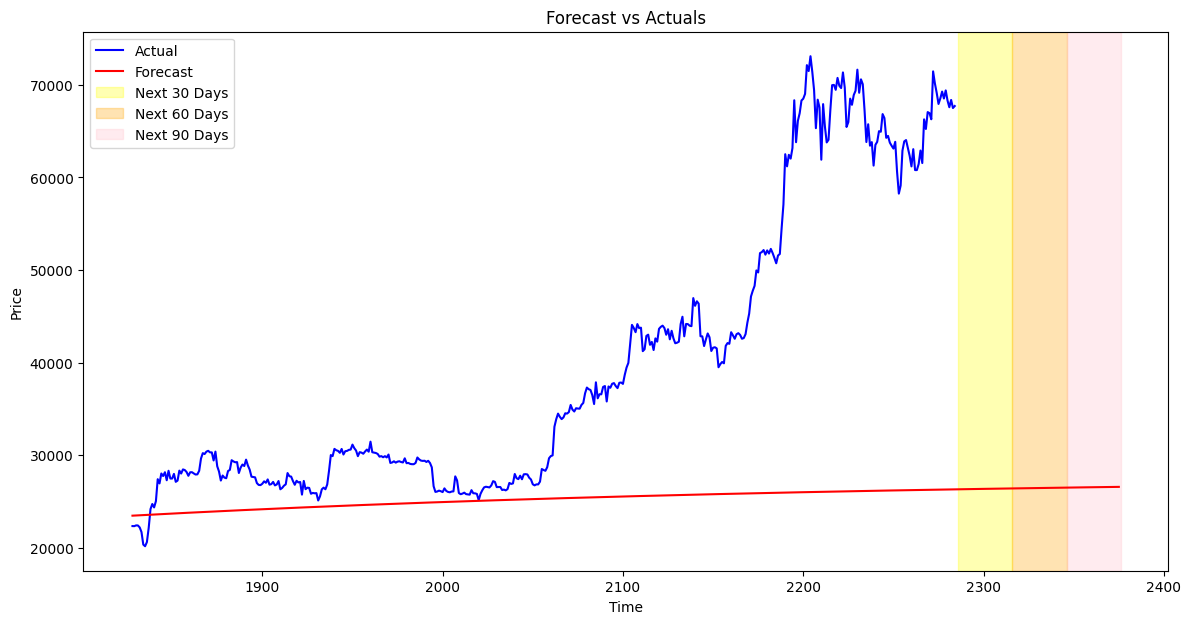

In [59]:
# Plotting the results
plt.figure(figsize=(14, 7))
plt.plot(test.index, test['Price'], label='Actual', color='blue')
# plt.plot(test_index, adjusted_forecasts_lr, label='Linear Regression Predict', color='green')
# plt.plot(test_index, adjusted_forecasts_arima, label='Arima Predict', color='black')
# plt.plot(test_index, adjusted_forecasts_dt, label='Decision Tree Predict', color='pink')
plt.plot(test_index, adjusted_forecasts_combined, label='Forecast', color='red')
# plt.plot(future_dates, adjusted_forecasts_combined, label='Future Forecast', color='green')

# Highlight the next 30, 60, 90 days predictions
plt.axvspan(future_index - 90, future_index - 60, color='yellow', alpha=0.3, label='Next 30 Days')
plt.axvspan(future_index - 60, future_index - 30, color='orange', alpha=0.3, label='Next 60 Days')
plt.axvspan(future_index - 30, future_index, color='pink', alpha=0.3, label='Next 90 Days')


plt.title('Forecast vs Actuals')
plt.title('Forecast vs Actuals')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

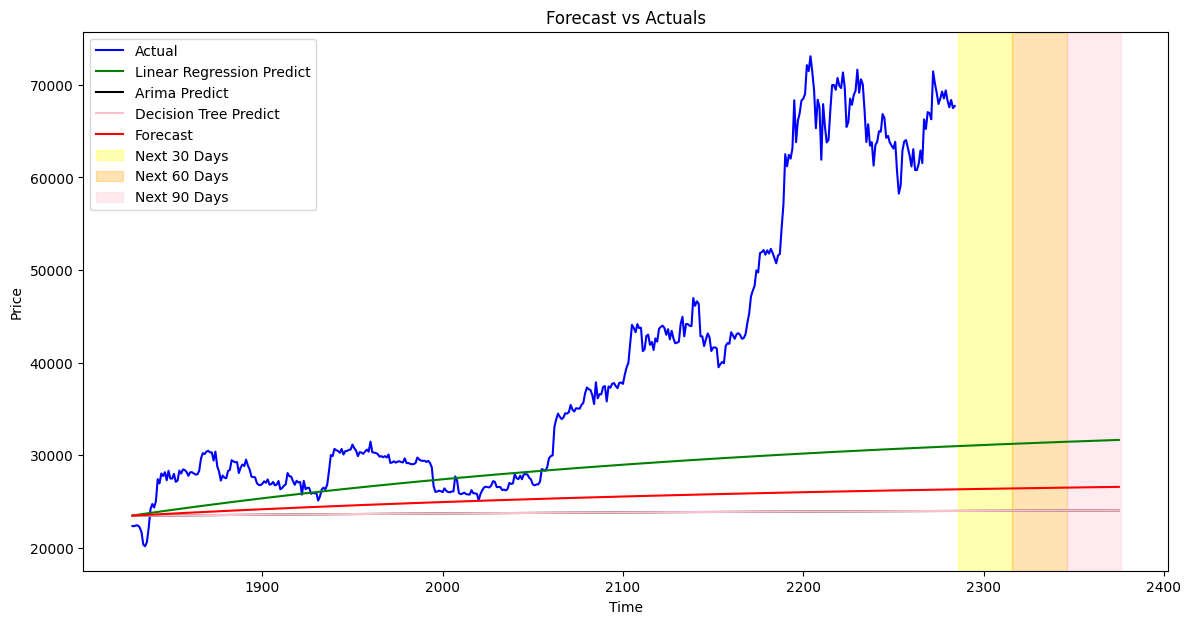

In [60]:
# Plotting the results
plt.figure(figsize=(14, 7))
plt.plot(test.index, test['Price'], label='Actual', color='blue')
plt.plot(test_index, adjusted_forecasts_lr, label='Linear Regression Predict', color='green')
plt.plot(test_index, adjusted_forecasts_arima, label='Arima Predict', color='black')
plt.plot(test_index, adjusted_forecasts_dt, label='Decision Tree Predict', color='pink')
plt.plot(test_index, adjusted_forecasts_combined, label='Forecast', color='red')
# plt.plot(future_dates, adjusted_forecasts_combined, label='Future Forecast', color='green')

# Highlight the next 30, 60, 90 days predictions
plt.axvspan(future_index - 90, future_index - 60, color='yellow', alpha=0.3, label='Next 30 Days')
plt.axvspan(future_index - 60, future_index - 30, color='orange', alpha=0.3, label='Next 60 Days')
plt.axvspan(future_index - 30, future_index, color='pink', alpha=0.3, label='Next 90 Days')


plt.title('Forecast vs Actuals')
plt.title('Forecast vs Actuals')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

# Forecast in all data 

In [61]:
# Forecast for test set using adjusted models
adjusted_forecasts_arima = arima_train_forecast.iloc[-1] + adjusted_arima_model.predict(start=0, end=len(errors_arima) + len(test) + future_steps)
adjusted_forecasts_lr = lr_train_forecast[-1] + adjusted_lr_model.predict(start=0, end=len(errors_arima) + len(test) + future_steps)
adjusted_forecasts_dt = dt_train_forecast[-1] + adjusted_dt_model.predict(start=0, end=len(errors_arima) + len(test) + future_steps)

In [62]:
adjusted_forecasts_combined = np.mean([adjusted_forecasts_arima, adjusted_forecasts_lr, adjusted_forecasts_dt], axis=0)

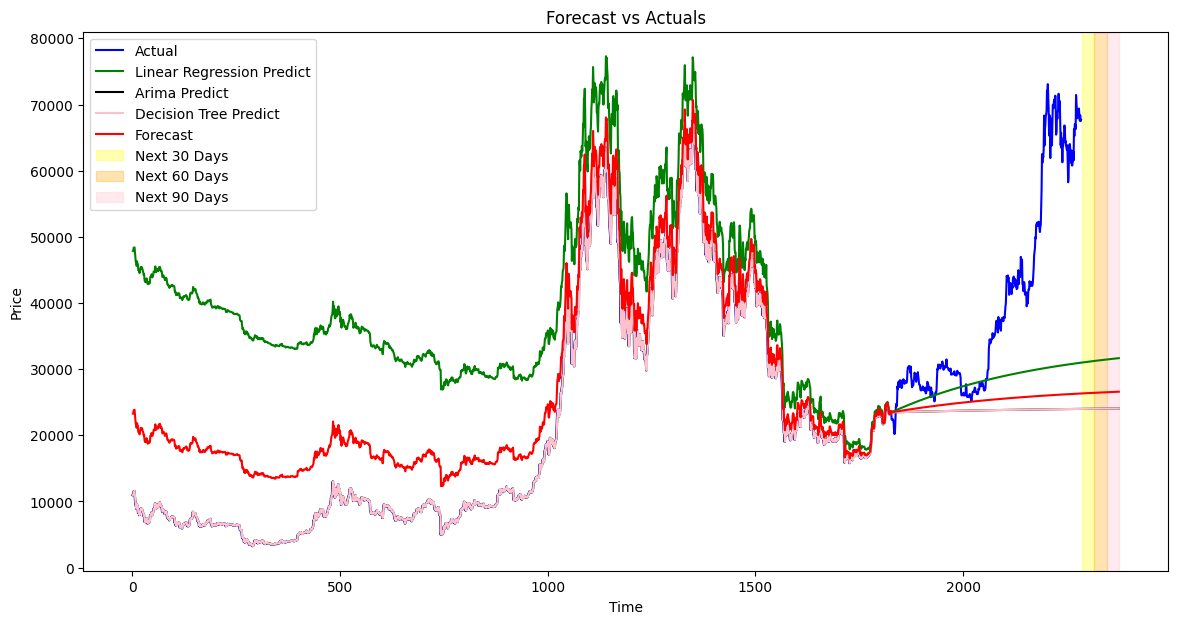

In [63]:
# Plotting the results
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Price'], label='Actual', color='blue')
plt.plot(future_dates, adjusted_forecasts_lr, label='Linear Regression Predict', color='green')
plt.plot(future_dates, adjusted_forecasts_arima, label='Arima Predict', color='black')
plt.plot(future_dates, adjusted_forecasts_dt, label='Decision Tree Predict', color='pink')
plt.plot(future_dates, adjusted_forecasts_combined, label='Forecast', color='red')

# Highlight the next 30, 60, 90 days predictions
plt.axvspan(future_index - 90, future_index - 60, color='yellow', alpha=0.3, label='Next 30 Days')
plt.axvspan(future_index - 60, future_index - 30, color='orange', alpha=0.3, label='Next 60 Days')
plt.axvspan(future_index - 30, future_index, color='pink', alpha=0.3, label='Next 90 Days')



plt.title('Forecast vs Actuals')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

# Use 3 statsmodel